# <B> Anormaly Detection based on AutoEncoder </B>
* Container: codna_pytorch_p39

## AutoEncoder based anomaly detection

- **RaPP** - Novelty Detection with Reconstruction along Projection Pathway <br>
<p align="center">
    <img src="imgs/rapp-f1.png" width="1100" height="300" style="display: block; margin: 0 auto"/>
</p>
<p align="center">
    <img src="imgs/rapp-f2.png" width="1100" height="300" style="display: block; margin: 0 auto"/>
</p>

    * [Ppaer, ICLR 2020] https://openreview.net/attachment?id=HkgeGeBYDB&name=original_pdf
    * [Desc, KOREAN] [RaPP](https://makinarocks.github.io/rapp/)
    * [Supplement #1] [Autoencoder based Anomaly Detection](https://makinarocks.github.io/Autoencoder-based-anomaly-detection/)
    * [Supplement #2] [Reference code (github)](https://github.com/Aiden-Jeon/RaPP)
        

## AutoReload

In [5]:
%load_ext autoreload
%autoreload 2

## parameter store 설정

In [6]:
import boto3
from utils.ssm import parameter_store

In [7]:
strRegionName=boto3.Session().region_name
pm = parameter_store(strRegionName)
prefix = pm.get_params(key="PREFIX")

## pramamters for tasks

In [8]:
account_id = pm.get_params(key="-".join([prefix, "ACCOUNT-ID"]))
defaulut_bucket = pm.get_params(key="-".join([prefix, "BUCKET"]))
sagemaker_role = pm.get_params(key="-".join([prefix, "SAGEMAKER-ROLE-ARN"]))
s3_data_path = pm.get_params(key="-".join([prefix, "S3-DATA-PATH"]))

In [9]:
print (f"prefix: {prefix}")
print (f"account_id: {account_id}")
print (f"defaulut_bucket: {defaulut_bucket}")
print (f"sagemaker_role: {sagemaker_role}")
print (f"s3_data_path: {s3_data_path}")

prefix: ad-ts
account_id: 419974056037
defaulut_bucket: sm-anomaly-detection
sagemaker_role: arn:aws:iam::419974056037:role/service-role/AmazonSageMaker-ExecutionRole-20221206T163436
s3_data_path: s3://sm-anomaly-detection/data


## 1. Data manipulation and visualization

In [10]:
import os
import pandas as pd
from utils.util import plot_click_w_fault_and_res, plot_click_w_fault_res_ad, plot_click_w_ad_exp

* load data and derive features

In [11]:
clicks_1T = pd.read_csv(os.path.join(s3_data_path, "clicks_1T.csv"), parse_dates=["timestamp"]).set_index("timestamp")
clicks_1T['residual'] = clicks_1T['click'] - clicks_1T['user'] 
clicks_1T['fault'] = pd.read_csv(os.path.join(s3_data_path, "fault_label_1T.csv"), header=None).values[0] ## label

In [12]:
print (f'data shape: {clicks_1T.shape}')
print (f'timestamp min: {clicks_1T.index.min()}, max: {clicks_1T.index.max()}')

data shape: (12960, 5)
timestamp min: 2020-07-07 00:00:00, max: 2020-07-15 23:59:00


* visualization

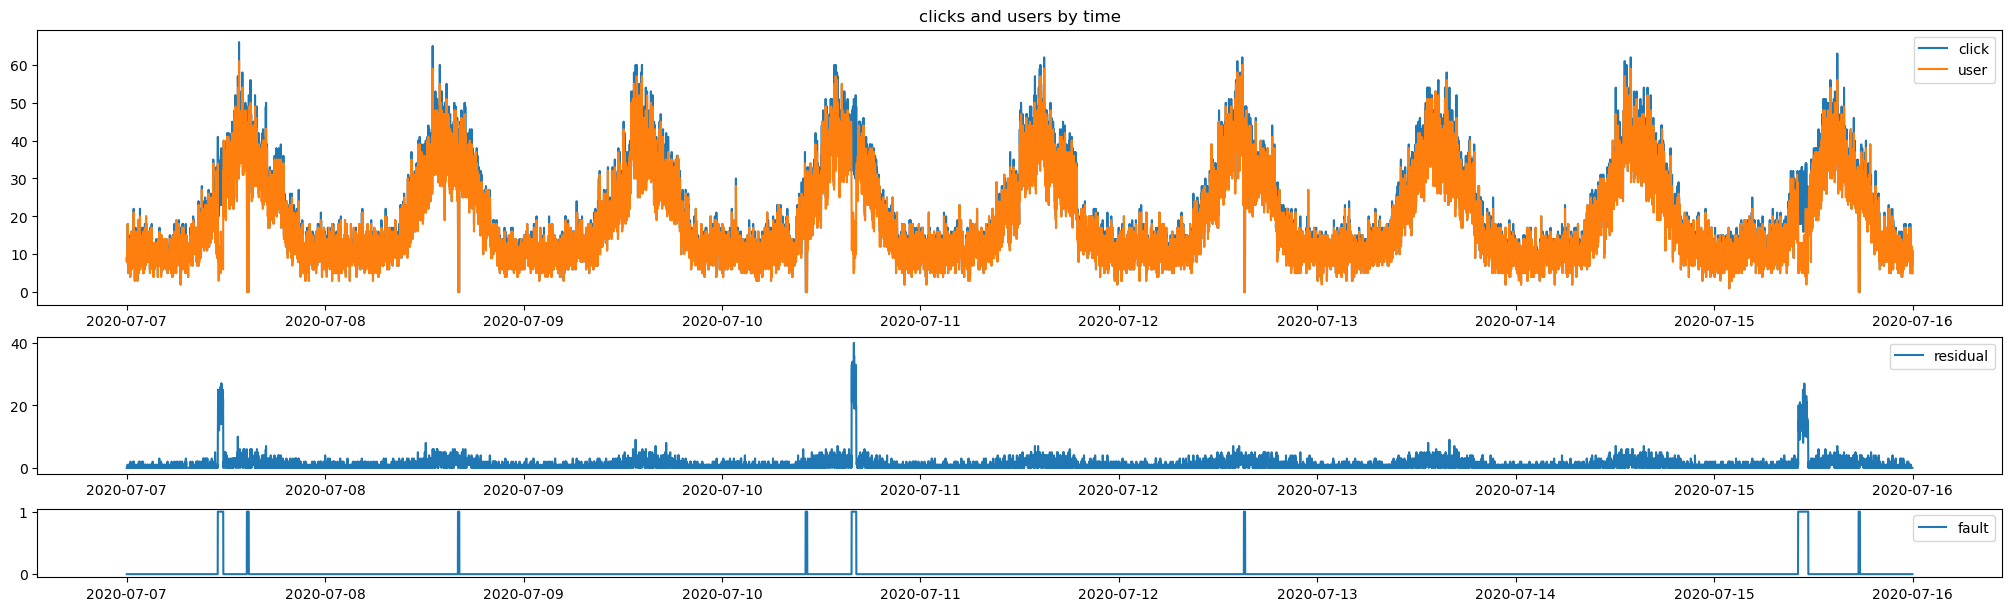

In [13]:
plot_click_w_fault_and_res(clicks_1T)

* upload data to s3 and local

In [14]:
train_data_name = "merged_clicks_1T.csv"
clicks_1T.to_csv(os.path.join(s3_data_path, train_data_name), index=True) # to s3
clicks_1T.to_csv(os.path.join("./data", train_data_name), index=True) # to local

print (f'train_data_name: {train_data_name}')

train_data_name: merged_clicks_1T.csv


## 2. Processing-job for preprocessing

In [15]:
import os
import sagemaker
from sagemaker.pytorch.estimator import PyTorch
from sagemaker.processing import ProcessingInput, ProcessingOutput, FrameworkProcessor

* params for processing job

In [16]:
local_mode = True

if local_mode: 
    instance_type = 'local'
    
    import os
    from sagemaker.local import LocalSession
    
    sagemaker_session = LocalSession()
    data_path = str(os.path.join("file://", os.getcwd(), "data"))
    
else:
    instance_type = "ml.m5.xlarge" ## "ml.g4dn.xlarge"
    sagemaker_session = sagemaker.Session()
    data_path = s3_data_path
        
print (f"instance-type: {instance_type}")
print (f'role: {sagemaker_role}')
print (f"bucket: {defaulut_bucket}")
print (f"dataset-path: {data_path}")
print (f"sagemaker_session: {sagemaker_session}")

instance-type: local
role: arn:aws:iam::419974056037:role/service-role/AmazonSageMaker-ExecutionRole-20221206T163436
bucket: sm-anomaly-detection
dataset-path: /home/ec2-user/SageMaker/anomaly-detection/data
sagemaker_session: <sagemaker.local.local_session.LocalSession object at 0x7f2fe26a5730>


* Define processing job

In [17]:
dataset_processor = FrameworkProcessor(
    estimator_cls=PyTorch,
    framework_version="1.13.1",
    py_version="py39",
    image_uri=None,
    instance_type=instance_type,
    instance_count=1,
    role=sagemaker_role,
    base_job_name="preprocessing", # bucket에 보이는 이름 (pipeline으로 묶으면 pipeline에서 정의한 이름으로 bucket에 보임)
    sagemaker_session=sagemaker_session
)

proc_prefix = "/opt/ml/processing"

output_path = os.path.join(
    "s3://{}".format(defaulut_bucket),
    prefix,
    "preprocessing",
    "output"
)

In [18]:
output_path

's3://sm-anomaly-detection/ad-ts/preprocessing/output'

In [19]:
dataset_processor.run(
    #job_name="preprocessing", ## 이걸 넣어야 캐시가 작동함, 안그러면 프로세서의 base_job_name 이름뒤에 날짜 시간이 붙어서 캐시 동작 안함
    #git_config=git_config,
    code='preprocessing.py', #소스 디렉토리 안에서 파일 path
    source_dir= "./src/preprocessing", #현재 파일에서 소스 디렉토리 상대경로 # add processing.py and requirements.txt here
    inputs=[
        ProcessingInput(
            input_name="input-data",
            source=data_path,
            destination=os.path.join(proc_prefix, "input")
        ),
    ],
    outputs=[       
        ProcessingOutput(
            output_name="output-data",
            source=os.path.join(proc_prefix, "output"),
            destination=output_path
        ),
    ],
    arguments=[
        "--proc_prefix", proc_prefix, \
        "--shingle_size", "4", \
        "--train_data_name", train_data_name
    ]
)

INFO:sagemaker:Creating processing-job with name preprocessing-2023-03-31-04-33-04-881
INFO:sagemaker.local.local_session:Starting processing job
INFO:botocore.credentials:Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole
INFO:sagemaker.local.image:No AWS credentials found in session but credentials from EC2 Metadata Service are available.
INFO:sagemaker.local.image:docker compose file: 
networks:
  sagemaker-local:
    name: sagemaker-local
services:
  algo-1-dbnq3:
    container_name: wh0oogdm35-algo-1-dbnq3
    entrypoint:
    - /bin/bash
    - /opt/ml/processing/input/entrypoint/runproc.sh
    - --proc_prefix
    - /opt/ml/processing
    - --shingle_size
    - '4'
    - --train_data_name
    - merged_clicks_1T.csv
    environment: []
    image: 763104351884.dkr.ecr.us-east-1.amazonaws.com/pytorch-training:1.13.1-cpu-py39
    networks:
      sagemaker-local:
        aliases:
        - algo-1-dbnq3
    stdin_open: true
    tty: true
    volumes:
    - /tmp/tmp8jjbt

Creating wh0oogdm35-algo-1-dbnq3 ... 
Creating wh0oogdm35-algo-1-dbnq3 ... done
Attaching to wh0oogdm35-algo-1-dbnq3
wh0oogdm35-algo-1-dbnq3 | Received arguments Namespace(proc_prefix='/opt/ml/processing', shingle_size=4, train_data_name='merged_clicks_1T.csv')
wh0oogdm35-algo-1-dbnq3 | Train: (12830, 5), Test: (130, 5)
wh0oogdm35-algo-1-dbnq3 | train_x: (12830, 4), train_y: (12830, 1), test_x: (130, 4), test_y: (130, 1)
wh0oogdm35-algo-1-dbnq3 | 12830 (12827, 16)
wh0oogdm35-algo-1-dbnq3 | 12830 (12827, 4)
wh0oogdm35-algo-1-dbnq3 | 130 (127, 16)
wh0oogdm35-algo-1-dbnq3 | 130 (127, 4)
wh0oogdm35-algo-1-dbnq3 | train_x_scaled_shingle: (12827, 16)
wh0oogdm35-algo-1-dbnq3 | train_y_shingle: (12827, 1)
wh0oogdm35-algo-1-dbnq3 | check label: [12827]
wh0oogdm35-algo-1-dbnq3 | fault cnt, train_y_shingle: [203.], train_y: [203]
wh0oogdm35-algo-1-dbnq3 | # features: 4, shingle_size: 4
wh0oogdm35-algo-1-dbnq3 | test_x_scaled_shingle: (127, 16)
wh0oogdm35-algo-1-dbnq3 | test_y_shingle: (127, 1)
wh

===== Job Complete =====


* download preprocessed data to local

In [20]:
!aws s3 sync $output_path ./data/preprocessing --quiet

* save params

In [21]:
pm.put_params(key="-".join([prefix, "PREP-DATA-PATH"]), value=output_path, overwrite=True)
print (f'S3-PREP-DATA-PATH: {pm.get_params(key="-".join([prefix, "PREP-DATA-PATH"]))}')

S3-PREP-DATA-PATH: s3://sm-anomaly-detection/ad-ts/preprocessing/output


## 3. Training-job for anomaly detection

* check gpu

In [22]:
import torch

In [23]:
if torch.cuda.is_available():
    for i in range(torch.cuda.device_count()):
        print(f"# DEVICE {i}: {torch.cuda.get_device_name(i)}")
        print("- Memory Usage:")
        print(f"  Allocated: {round(torch.cuda.memory_allocated(i)/1024**3,1)} GB")
        print(f"  Cached:    {round(torch.cuda.memory_reserved(i)/1024**3,1)} GB\n")
        
else:
    print("# GPU is not available")
    
# GPU 할당 변경하기
GPU_NUM = 0 # 원하는 GPU 번호 입력
device = torch.device(f'cuda:{GPU_NUM}' if torch.cuda.is_available() else 'cpu')
torch.cuda.set_device(device) # change allocation of current GPU

print ('# Current cuda device: ', torch.cuda.current_device()) # check

# DEVICE 0: Tesla V100-SXM2-16GB
- Memory Usage:
  Allocated: 0.0 GB
  Cached:    0.0 GB

# Current cuda device:  0


In [24]:
import os
from sagemaker.pytorch.estimator import PyTorch
from sagemaker.inputs import TrainingInput

* **Set Up SageMaker Experiment**
    - Create or load [SageMaker Experiment](https://docs.aws.amazon.com/sagemaker/latest/dg/experiments.html) for the example training job. This will create an experiment trial object in SageMaker.
    - **pip instatll sagemaker-experiments**

In [25]:
from time import strftime
from smexperiments.trial import Trial
from smexperiments.experiment import Experiment

In [26]:
def create_experiment(experiment_name):
    try:
        sm_experiment = Experiment.load(experiment_name)
    except:
        sm_experiment = Experiment.create(experiment_name=experiment_name)

In [27]:
def create_trial(experiment_name):
    create_date = strftime("%m%d-%H%M%s")
    sm_trial = Trial.create(trial_name=f'{experiment_name}-{create_date}',
                            experiment_name=experiment_name)

    job_name = f'{sm_trial.trial_name}'
    return job_name

* params for training job

In [28]:
# Set to True to enable SageMaker to run locally
local_mode = True


if local_mode:
    instance_type = "local_gpu"
    
    from sagemaker.local import LocalSession
    import os
    
    sagemaker_session = LocalSession()
    sagemaker_session.config = {'local': {'local_code': True}}
    
    local_data_dir = os.getcwd() + '/data/preprocessing'
    
    data_channels = {"train": f"file://{local_data_dir}", "validation": f"file://{local_data_dir}"}
    
else:
    
    instance_type = "ml.p3.2xlarge" #"ml.p3.2xlarge"#"ml.g4dn.8xlarge"#"ml.p3.2xlarge", 'ml.p3.16xlarge' , ml.g4dn.8xlarge
    
    sagemaker_session = sagemaker.Session()
    data_channels = {
        "train": pm.get_params(key="-".join([prefix, "PREP-DATA-PATH"])),
        "validation": pm.get_params(key="-".join([prefix, "PREP-DATA-PATH"]))
    }

instance_count = 1
use_spot_instances = False
if use_spot_instances:
    max_wait = 1*60*60
else:
    max_wait = None
    
max_wait = None
max_run = 1*60*60   
    
proc_prefix = "/opt/ml/processing"
#bucket_name = pm.get_params(key=prefix + "-BUCKET")

output_path = os.path.join(
    "s3://{}".format(defaulut_bucket),
    prefix,
    "training",
    "model-output"
)

code_location = os.path.join(
    "s3://{}".format(defaulut_bucket),
    prefix,
    "training",
    "backup_codes"
)

experiment_name = '-'.join([prefix, "experiments"])

num_re = "([0-9\\.]+)(e-?[[01][0-9])?"
metric_definitions = [
    {"Name": "Train loss", "Regex": f"loss={num_re}"},
    {"Name": "Train cos", "Regex": f"wer:{num_re}"},
    {"Name": "Val cos", "Regex": f"wer:{num_re}"}
]

kwargs = {}

In [29]:
print("experiment_name : {} \ntrain_instance_type : {} \ntrain_instance_count : {}\ndata_channels : {}\nexperiment_name : {}".format(experiment_name, instance_type, instance_count, data_channels, experiment_name))    

experiment_name : ad-ts-experiments 
train_instance_type : local_gpu 
train_instance_count : 1
data_channels : {'train': 'file:///home/ec2-user/SageMaker/anomaly-detection/data/preprocessing', 'validation': 'file:///home/ec2-user/SageMaker/anomaly-detection/data/preprocessing'}
experiment_name : ad-ts-experiments


* Define training job

In [30]:
estimator = PyTorch(
    entry_point="main.py", # the script we want to run
    source_dir="./src/training", # where our conf/script is
    #git_config=git_config,
    role=sagemaker_role,
    instance_type=instance_type,
    instance_count=instance_count,
    image_uri=None,
    framework_version="1.13.1", # version of PyTorch
    py_version="py39",
    volume_size=256,
    code_location = code_location,
    output_path=output_path,
    disable_profiler=True,
    debugger_hook_config=False,
    #hyperparameters={'config-path': 'conf'},
    #distribution={"smdistributed":{"dataparallel":{"enabled":True, "fp16": True}}},
    sagemaker_session=sagemaker_session,
    metric_definitions=metric_definitions,
    max_run=max_run,
    use_spot_instances=use_spot_instances,  # spot instance 활용
    max_wait=max_wait,
    enable_sagemaker_metrics=True,
    **kwargs
)

In [31]:
estimator.set_hyperparameters(
    epochs=500,
    batch_size=256, 
    lr=1e-2,
    shingle_size=4,
    num_features=4,
    workers=2
) 

In [32]:
if instance_type =='local_gpu': estimator.checkpoint_s3_uri = None

create_experiment(experiment_name)
job_name = create_trial(experiment_name)

estimator.fit(
    inputs=data_channels, 
    job_name=job_name,
    experiment_config={
      'TrialName': job_name,
      'TrialComponentDisplayName': job_name,
    },
    wait=True,
)

INFO:botocore.credentials:Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole
INFO:botocore.credentials:Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole
INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: ad-ts-experiments-0331-04331680237197
INFO:sagemaker.local.local_session:Starting training job
INFO:botocore.credentials:Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole
INFO:botocore.credentials:Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole
INFO:sagemaker.local.image:No AWS credentials found in session but credentials from EC2 Metadata Service are available.
INFO:sagemaker.local.image:docker compose file: 
networks:
  sagemaker-local:
    name: sagemaker-local
services:
  algo-1-hxe00:
    command: train
    container_name: bgfwo0pu6u-algo-1-hxe00
    deploy:
      resources:
        reservations:

Creating bgfwo0pu6u-algo-1-hxe00 ... 
Creating bgfwo0pu6u-algo-1-hxe00 ... done
Attaching to bgfwo0pu6u-algo-1-hxe00
bgfwo0pu6u-algo-1-hxe00 | 2023-03-31 04:33:19,343 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
bgfwo0pu6u-algo-1-hxe00 | 2023-03-31 04:33:19,362 sagemaker-training-toolkit INFO     No Neurons detected (normal if no neurons installed)
bgfwo0pu6u-algo-1-hxe00 | 2023-03-31 04:33:19,372 sagemaker-training-toolkit INFO     instance_groups entry not present in resource_config
bgfwo0pu6u-algo-1-hxe00 | 2023-03-31 04:33:19,374 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
bgfwo0pu6u-algo-1-hxe00 | 2023-03-31 04:33:19,377 sagemaker_pytorch_container.training INFO     Invoking user training script.
bgfwo0pu6u-algo-1-hxe00 | 2023-03-31 04:33:19,397 sagemaker-training-toolkit INFO     No Neurons detected (normal if no neurons installed)
bgfwo0pu6u-algo-1-hxe00 | 2023-03-31 04:33:19,407 sagemaker

In [33]:
estimator.model_data

's3://sm-anomaly-detection/ad-ts/training/model-output/ad-ts-experiments-0331-04331680237197/model.tar.gz'

* save params

In [34]:
pm.put_params(key="-".join([prefix, "S3-MODEL-ARTIFACT"]), value=estimator.model_data, overwrite=True)
print (f'S3-MODEL-ARTIFACT: {pm.get_params(key="-".join([prefix, "S3-MODEL-ARTIFACT"]))}')

S3-MODEL-ARTIFACT: s3://sm-anomaly-detection/ad-ts/training/model-output/ad-ts-experiments-0331-04331680237197/model.tar.gz


## 4. Deploy

* params for deployment

In [35]:
import time

In [42]:
# Set to True to enable SageMaker to run locally
local_mode = False

if local_mode:
    instance_type = "local_gpu"
    
    from sagemaker.local import LocalSession
    import os
    
    sagemaker_session = LocalSession()
    sagemaker_session.config = {'local': {'local_code': True}}
    
else:
    instance_type = "ml.p3.2xlarge" #"ml.p3.2xlarge"#"ml.g4dn.8xlarge"#"ml.p3.2xlarge", 'ml.p3.16xlarge' , ml.g4dn.8xlarge
    sagemaker_session = sagemaker.Session()
    
strEndpointName = f"endpoint-{prefix}-{int(time.time())}"
    
print (f'instance_type: {instance_type}')
print (f'sagemaker_session: {sagemaker_session}')
print (f"Endpoint-name: {strEndpointName}")

instance_type: ml.p3.2xlarge
sagemaker_session: <sagemaker.session.Session object at 0x7f2fbcfd5760>
Endpoint-name: endpoint-ad-ts-1680237478


* deploy

In [43]:
from sagemaker.pytorch.model import PyTorchModel
from sagemaker.serializers import CSVSerializer, NumpySerializer, JSONSerializer
from sagemaker.deserializers import JSONDeserializer, NumpyDeserializer

In [44]:
pm.get_params(key="-".join([prefix, "S3-MODEL-ARTIFACT"]))

's3://sm-anomaly-detection/ad-ts/training/model-output/ad-ts-experiments-0331-04331680237197/model.tar.gz'

In [45]:
esimator = PyTorchModel(
    source_dir="./src/deploy",
    entry_point="inference.py",
    model_data=pm.get_params(key="-".join([prefix, "S3-MODEL-ARTIFACT"])),
    role=sagemaker_role,
    framework_version='1.13.1',
    py_version='py39',
    model_server_workers=1,
)

In [46]:
predictor = esimator.deploy(
    endpoint_name=strEndpointName,
    instance_type=instance_type, 
    initial_instance_count=1,
    serializer=JSONSerializer('application/json'), ## 미적용 시 default: application/x-npy, boto3 기반 invocation시 무시
    deserializer=JSONDeserializer('application/json'), ## 미적용 시 default: application/x-npy, boto3 기반 invocation시 무시
    wait=False,  
    log=True,
)

INFO:sagemaker:Creating model with name: pytorch-inference-2023-03-31-04-38-00-199
INFO:sagemaker:Creating endpoint-config with name endpoint-ad-ts-1680237478
INFO:sagemaker:Creating endpoint with name endpoint-ad-ts-1680237478


In [47]:
strEndpointName

'endpoint-ad-ts-1680237478'

* inference (invocation)

In [48]:
import pickle

In [49]:
def from_pickle(obj_path):
    with open(file=obj_path, mode="rb") as f:
        obj=pickle.load(f)
    return obj

In [50]:
data_path = "./data/preprocessing/train_x_scaled_shingle.pkl"
data = from_pickle(data_path)
data = data[3, :]
dtype = data.dtype
shape = data.shape

In [51]:
print (f'data: {data}')
print (f'dtype: {dtype}')
print (f'shape: {shape}')

data: [-0.51680966 -1.29928169 -0.90804568 -0.51680966 -0.70864009 -0.88803734
 -0.88803734 -0.43954422 -0.76056935 -0.92933775 -0.92933775 -0.42303254
 -0.47309805 -0.47309805 -0.47309805 -0.0480089 ]
dtype: float64
shape: (16,)


* inference - using sagemaker SDK

In [52]:
payload={"INPUT": data.tolist(), "SHAPE":shape, "DTYPE": str(dtype)}
#payload = json.dumps(payload)

In [53]:
pred_results = predictor.predict(payload)
pred_results

ValidationError: An error occurred (ValidationError) when calling the InvokeEndpoint operation: Endpoint endpoint-ad-ts-1680237478 of account 419974056037 not found.

* inference - using boto3 SDK

In [ ]:
import json
import boto3

### boto3 기반 invocation시 runtime_client가 필요함
* 이때 엔드포인트의 위치 (local/cloud)를 반드시 구분해 줘야함

In [ ]:
if instance_type == 'local_gpu': runtime_client = sagemaker.local.LocalSagemakerRuntimeClient()    
else: runtime_client = boto3.Session().client('sagemaker-runtime')
runtime_client

In [ ]:
def invoke_endpoint(runtime_client, endpoint_name, payload, content_type):
    response = runtime_client.invoke_endpoint(
        EndpointName=endpoint_name, 
        ContentType=content_type, 
        Body=payload,
    )

    result = response['Body'].read().decode().splitlines()    
    
    return result

### [중요] boto3로 inference 할 때는 payload를 반드시 serialization 해서 넣어줘야 함
* sagemaker SDK는 deploy시 셋팅한 방식대로 serialization을 자동으로 해 준다
* boto3는 사용자가 직접 serialization을 한 후 inference 한다. (대신 serialization 자유도가 있다)

In [ ]:
payload = json.dumps(payload)

In [ ]:
start_time = time.time()
result = invoke_endpoint(
    runtime_client=runtime_client,
    endpoint_name=strEndpointName, 
    payload=payload,
    content_type='application/json'
)

print("--- %s seconds ---" % (time.time() - start_time))
print('result: ',  eval(result[0]))

* get anomaly scores

In [ ]:
data_path = "./data/preprocessing/train_x_scaled_shingle.pkl"
data = from_pickle(data_path)

In [ ]:
%%time
pred_results = []
for idx, record in enumerate(data):
    payload={"INPUT": record.tolist(), "SHAPE":shape, "DTYPE": str(dtype)}
    pred = predictor.predict(payload)
    pred_results.append(pred['pred'][0])
    #if idx == 5: break
    if idx % 1000 == 0: print (f'{idx}/{data.shape[0]}')
#pdScores = pd.DataFrame(pred_results)

In [ ]:
pdScores = pd.DataFrame(pred_results)

In [ ]:
data_path = "./data/preprocessing/train_y_shingle.pkl"
train_y_shingle = from_pickle(data_path)

train_data_ratio = 0.99
shingle_size = 4
pdTrain_raw = clicks_1T[["page", "user", "click", "residual", "fault"]][:int(clicks_1T.shape[0] * train_data_ratio)].iloc[shingle_size-1:, :]
pdTrain_raw = pdTrain_raw.rename(columns={"page": "url"})
print (f"train_y_shingle: {train_y_shingle.shape}")

In [ ]:
pdScores.index = pdTrain_raw.index

In [ ]:
pdScores = pd.concat([pdTrain_raw, pdScores], axis=1)

In [ ]:
pdScores

## 4. Plotting the Prediction

Plot the anomalous points detected by AE.

###  - For Reconstruction Error

* Check the distribution of our anomaly score.

In [111]:
import seaborn as sns
import matplotlib.pyplot as plt

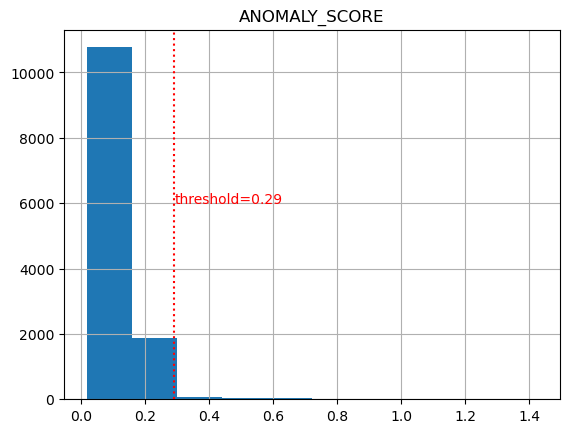

3 sigma threshoud = 0.29046471989802036


In [112]:
threshold_re = pdScores['ANOMALY_SCORE'].mean() + 2.5*pdScores['ANOMALY_SCORE'].std()

pdPlot = pd.DataFrame(pdScores['ANOMALY_SCORE'])
pdPlot.hist()
plt.axvline(x=threshold_re, linestyle=':', c='r')
plt.annotate('threshold={}'.format(round(threshold_re,2)), xy=(threshold_re,6000), color='r')
plt.show()

print('3 sigma threshoud = {}'.format(threshold_re))

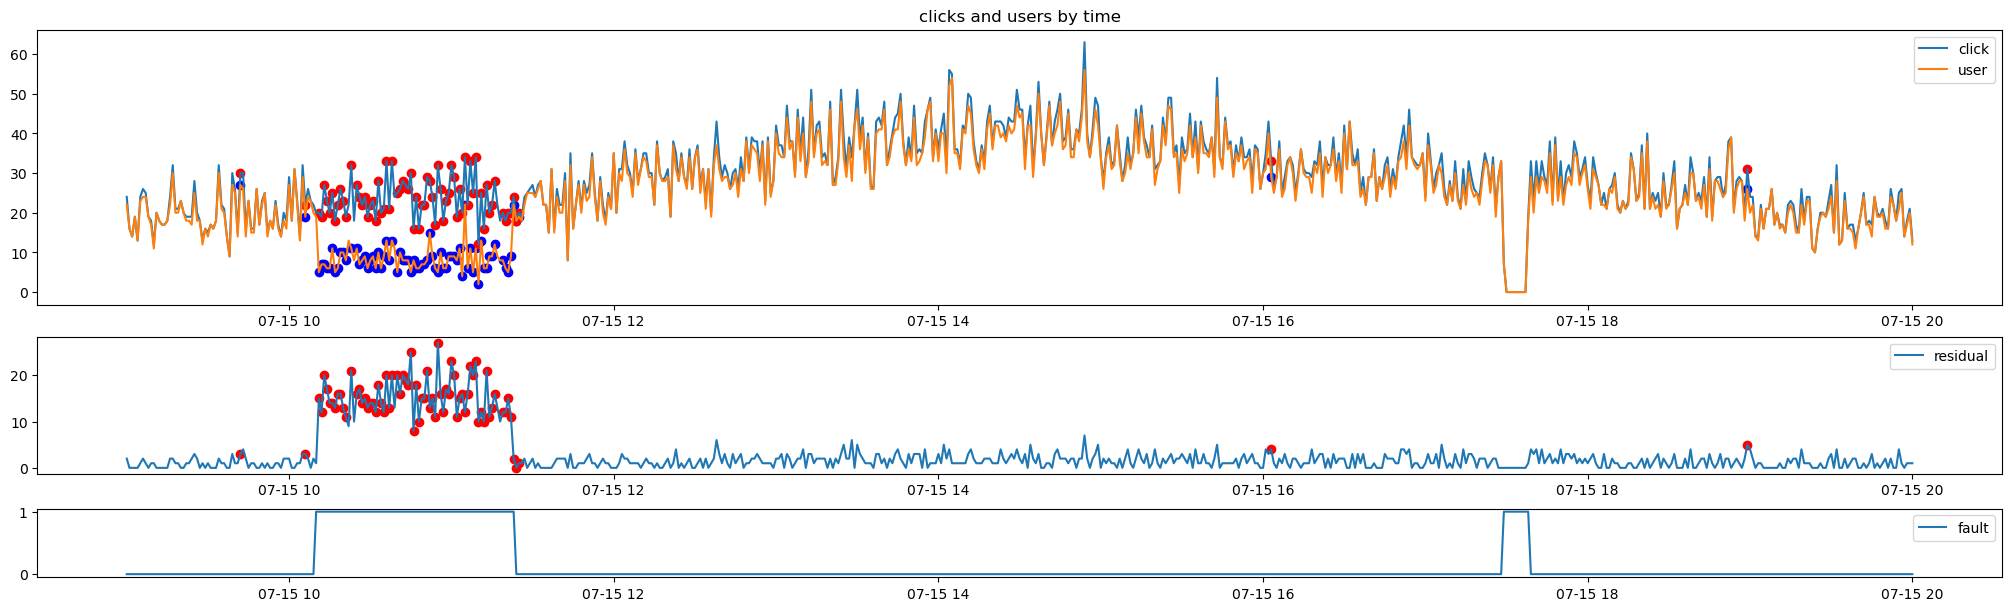

In [113]:
anomalous = pdScores.query("ANOMALY_SCORE > @threshold_re")
stime = "2020-07-15 09:00:00" # "2012-03-13 08:00:00"
etime = "2020-07-15 20:00:00" # "2012-03-13 20:00:00"
plot_click_w_fault_res_ad(pdScores, anomalous, threshold_re, start_dt=stime, end_dt=etime)

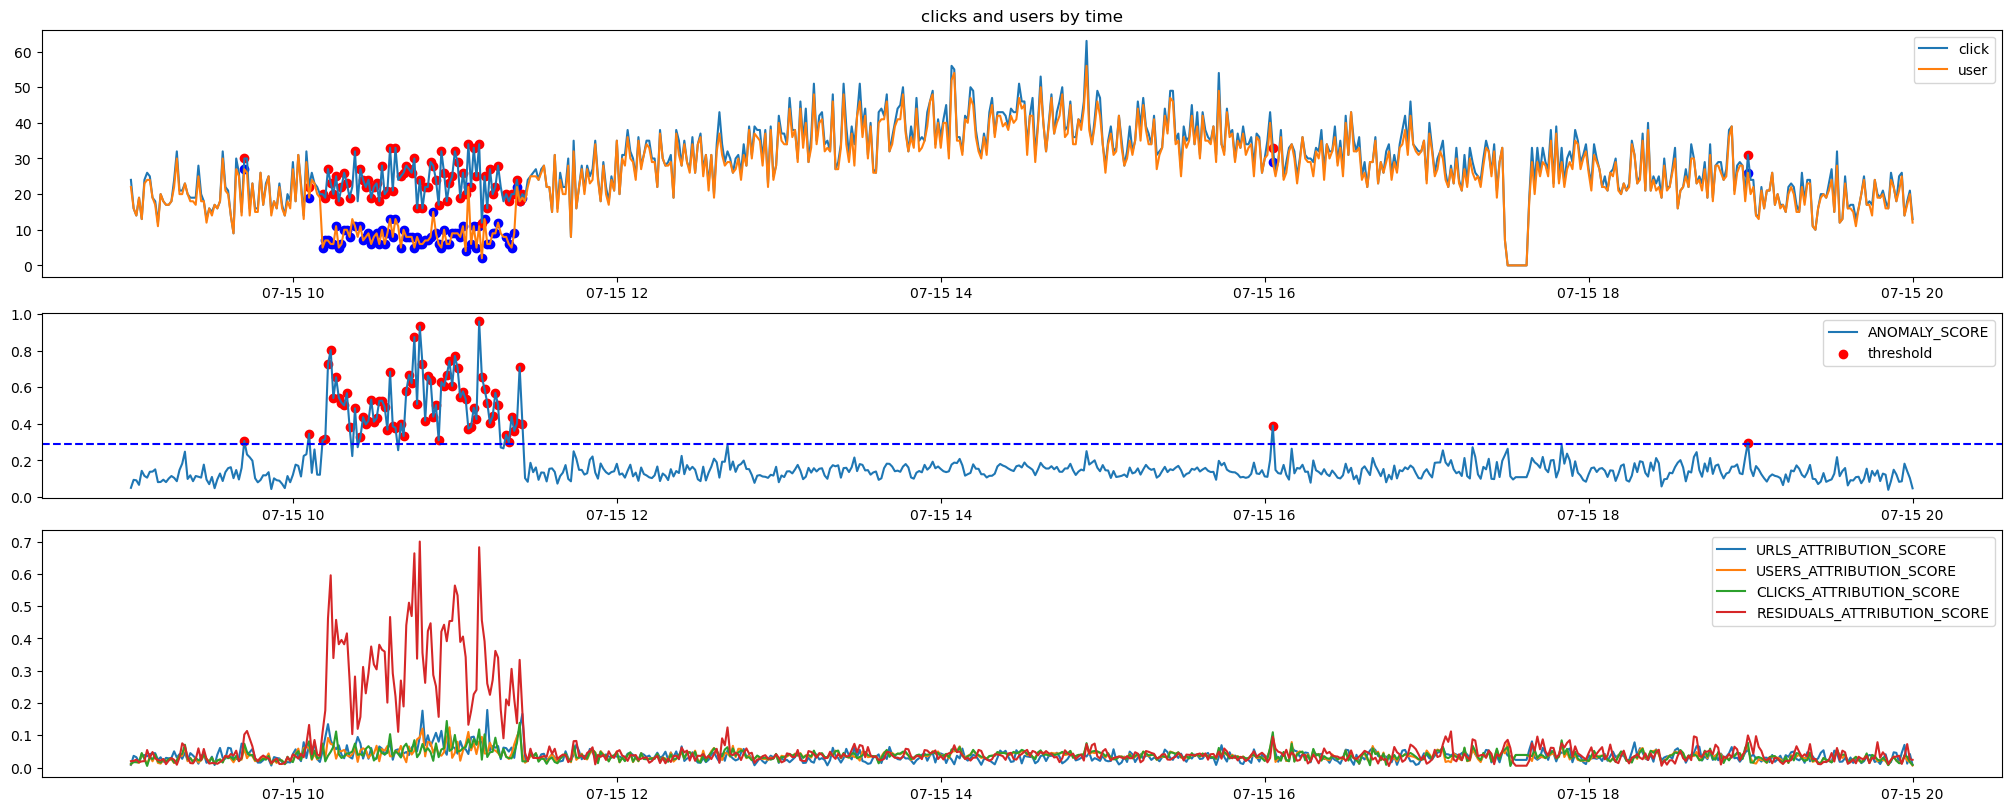

In [114]:
plot_click_w_ad_exp(pdScores, anomalous, threshold_re, start_dt=stime, end_dt=etime)

In [115]:
pdAnomal = pdScores.query("ANOMALY_SCORE > @threshold_re")[["ANOMALY_SCORE", "URLS_ATTRIBUTION_SCORE", "USERS_ATTRIBUTION_SCORE", \
                                                         "CLICKS_ATTRIBUTION_SCORE", "RESIDUALS_ATTRIBUTION_SCORE", "ANOMALY_SCORE_SAP"]] 

/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


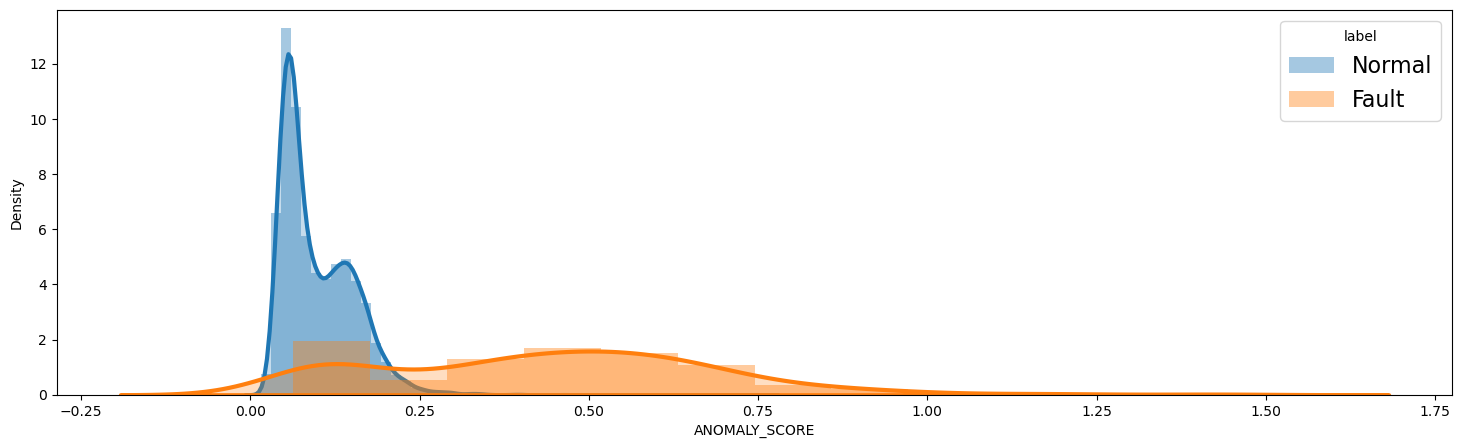

In [116]:
plt.figure(figsize = (18,5))
fault_types = [0, 1]
for fault_type in fault_types:
    
    if fault_type == 0: label = "Normal"
    else: label = "Fault"
    sns.distplot(
        pdScores[pdScores.fault==fault_type]["ANOMALY_SCORE"],
        hist=True,
        kde=True,
        kde_kws={"shade":True, "linewidth":3},
        label=label
    )
plt.legend(prop={"size":16}, title = "label")

* performance metric

In [129]:
precision = pdScores.query("fault == 1 and ANOMALY_SCORE > @threshold_re").shape[0] / pdScores.query("ANOMALY_SCORE > @threshold_re").shape[0]
recall = pdScores.query("fault == 1 and ANOMALY_SCORE > @threshold_re").shape[0] / pdScores.query("fault == 1").shape[0]
f1_score = 2*(precision*recall)/(precision+recall)

In [130]:
print (f'Precision: {precision}')
print (f'Recall: {recall}')
print (f'f1_score: {f1_score}')

Precision: 0.7411167512690355
Recall: 0.7192118226600985
f1_score: 0.73


###  - For SAP Score

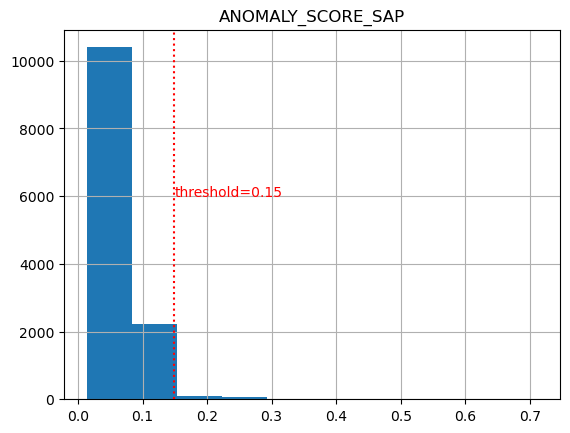

3 sigma threshoud = 0.14928611179725768


In [131]:
threshold_sap = pdScores['ANOMALY_SCORE_SAP'].mean() + 2.5*pdScores['ANOMALY_SCORE_SAP'].std()

pdPlot = pd.DataFrame(pdScores['ANOMALY_SCORE_SAP'])
pdPlot.hist()
plt.axvline(x=threshold_sap, linestyle=':', c='r')
plt.annotate('threshold={}'.format(round(threshold_sap,2)), xy=(threshold_sap,6000), color='r')
plt.show()

print('3 sigma threshoud = {}'.format(threshold_sap))

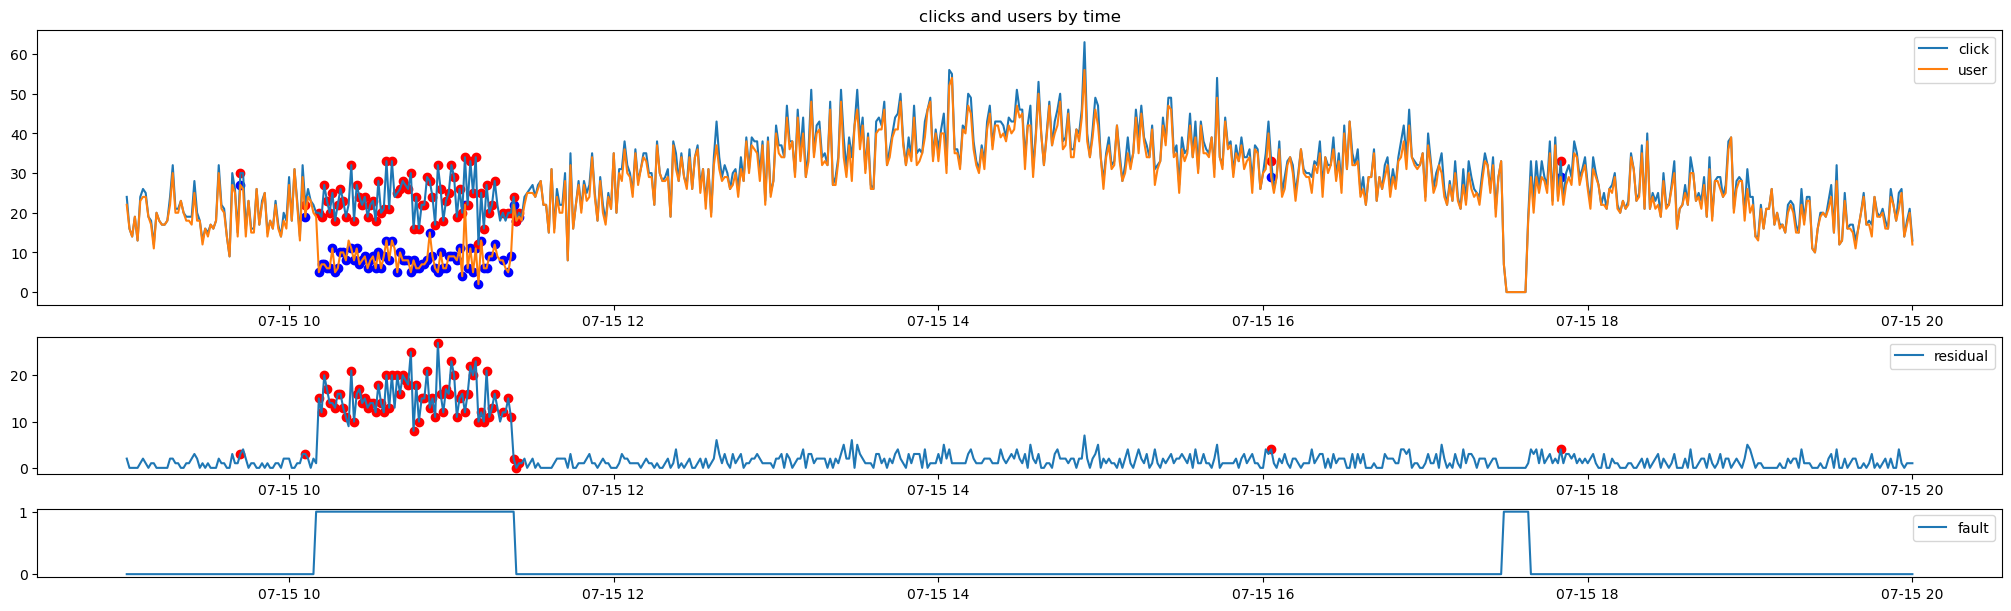

In [132]:
anomalous = pdScores.query("ANOMALY_SCORE_SAP > @threshold_sap")
stime = "2020-07-15 09:00:00" # "2012-03-13 08:00:00"
etime = "2020-07-15 20:00:00" # "2012-03-13 20:00:00"
plot_click_w_fault_res_ad(pdScores, anomalous, threshold_sap, start_dt=stime, end_dt=etime)

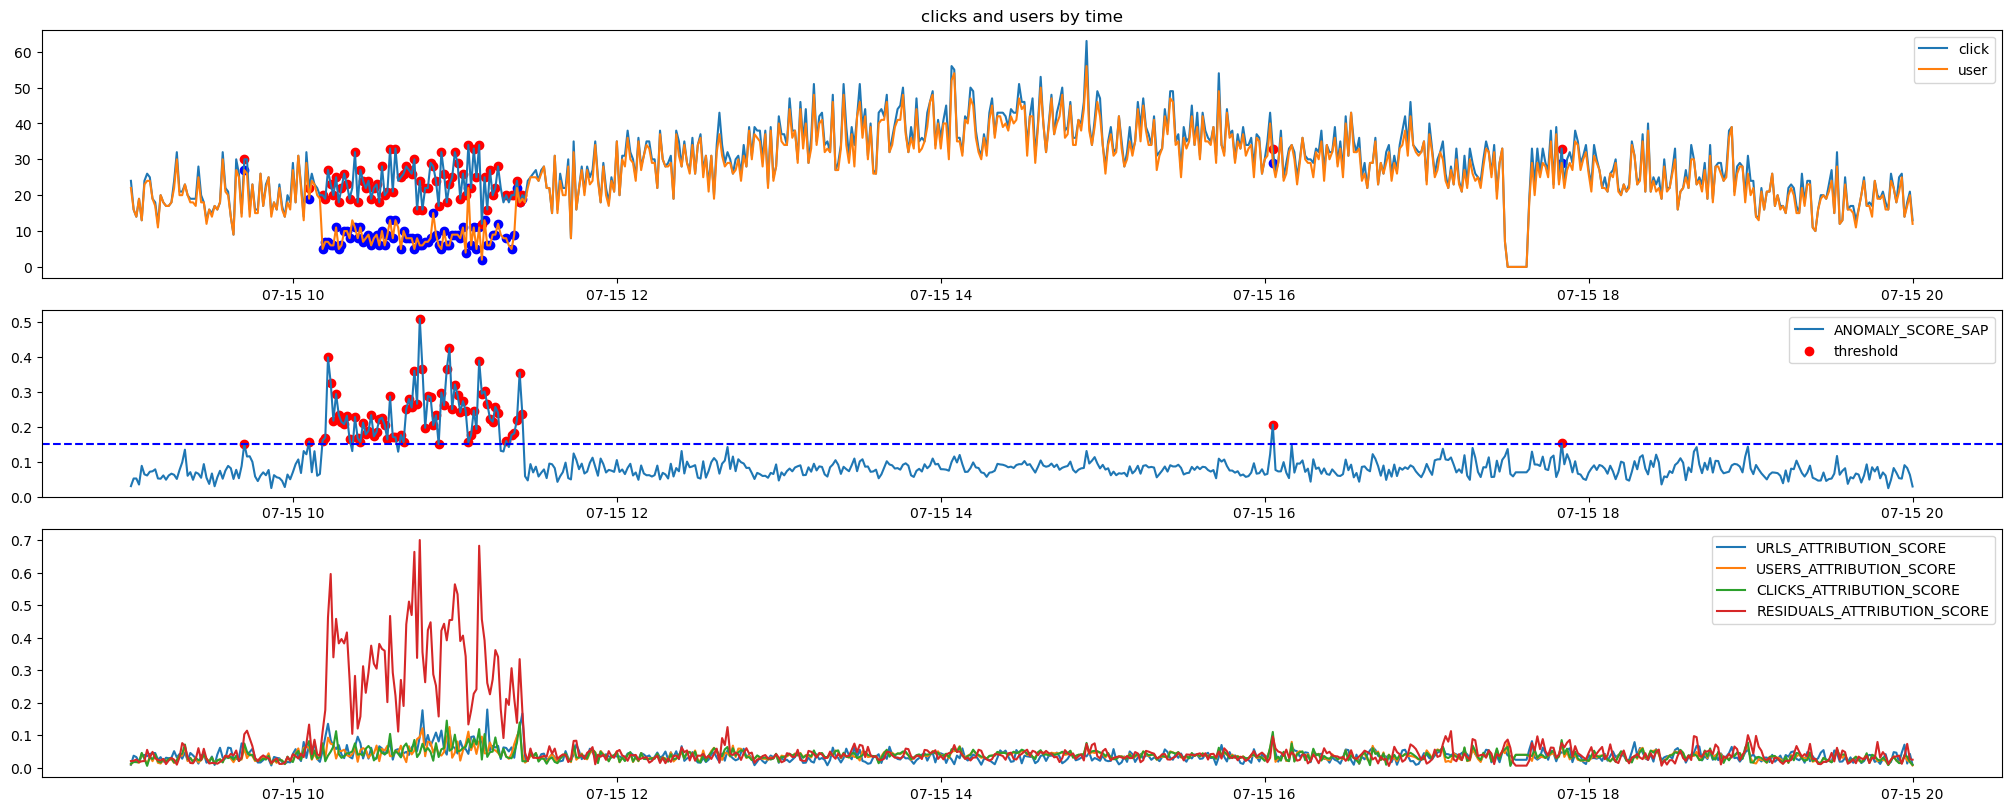

In [133]:
plot_click_w_ad_exp(pdScores, anomalous, threshold_sap, start_dt=stime, end_dt=etime, score="ANOMALY_SCORE_SAP")

/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


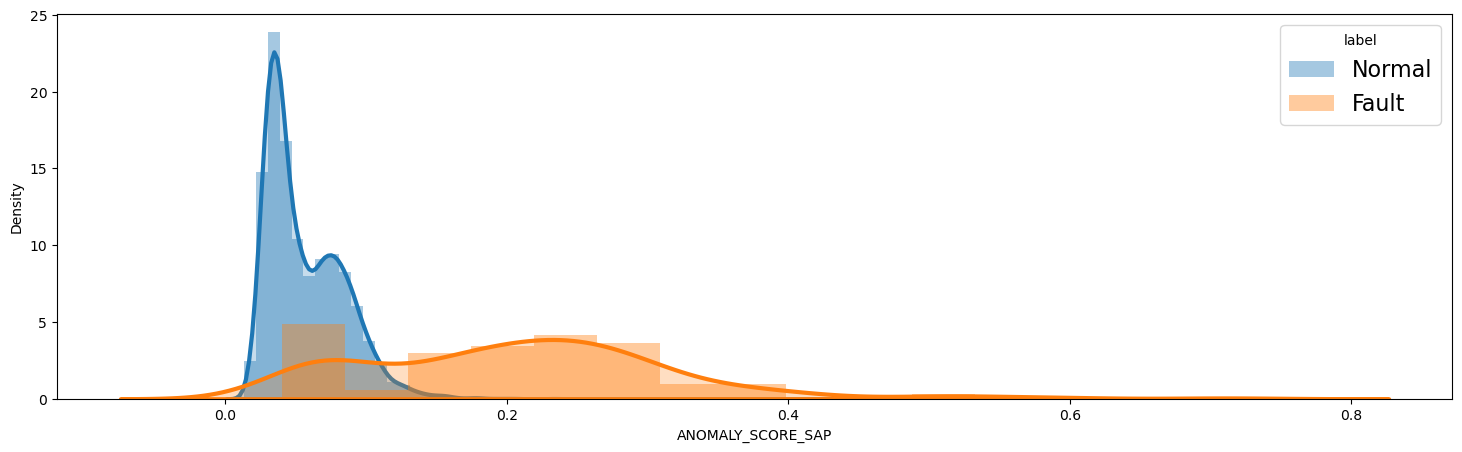

In [134]:
plt.figure(figsize = (18,5))
fault_types = [0, 1]
for fault_type in fault_types:
    
    if fault_type == 0: label = "Normal"
    else: label = "Fault"
    sns.distplot(
        pdScores[pdScores.fault==fault_type]["ANOMALY_SCORE_SAP"],
        hist=True,
        kde=True,
        kde_kws={"shade":True, "linewidth":3},
        label=label
    )
plt.legend(prop={"size":16}, title = "label")

In [135]:
precision = pdScores.query("fault == 1 and ANOMALY_SCORE_SAP > @threshold_sap").shape[0] / pdScores.query("ANOMALY_SCORE_SAP > @threshold_sap").shape[0]
recall = pdScores.query("fault == 1 and ANOMALY_SCORE_SAP > @threshold_sap").shape[0] / pdScores.query("fault == 1").shape[0]
f1_score = 2*(precision*recall)/(precision+recall)

In [136]:
print (f'Precision: {precision}')
print (f'Recall: {recall}')
print (f'f1_score: {f1_score}')

Precision: 0.6952380952380952
Recall: 0.7192118226600985
f1_score: 0.7070217917675545


## Clean up

* delete endpoint

In [138]:
class clean_up():
    
    def __init__(self, ):    
        pass
    
    def delete_endpoint(self, client, endpoint_name ,is_del_model=True):
        
        response = client.describe_endpoint(EndpointName=endpoint_name)
        EndpointConfigName = response['EndpointConfigName']

        response = client.describe_endpoint_config(EndpointConfigName=EndpointConfigName)
        model_name = response['ProductionVariants'][0]['ModelName']    

        if is_del_model: # 모델도 삭제 여부 임.
            client.delete_model(ModelName=model_name)    

        client.delete_endpoint(EndpointName=endpoint_name)
        client.delete_endpoint_config(EndpointConfigName=EndpointConfigName)    

        print(f'--- Deleted model: {model_name}')
        print(f'--- Deleted endpoint: {endpoint_name}')
        print(f'--- Deleted endpoint_config: {EndpointConfigName}')  


In [139]:
clean = clean_up()
sm_client = boto3.client('sagemaker')
clean.delete_endpoint(sm_client, strEndpointName ,is_del_model=True)

--- Deleted model: pytorch-inference-2023-03-31-03-51-25-103
--- Deleted endpoint: endpoint-ad-ts-1680234682
--- Deleted endpoint_config: endpoint-ad-ts-1680234682


In [140]:
                #print ("anomal_score", anomal_score, anomal_score.size())
                
#                 y_bool=y.bool().flatten()
#                 falult_indices = y_bool.nonzero()
#                 normal_indices = torch.where(y_bool == False)[0]
                
#                 fault_score = anomal_score.take(falult_indices).sum()
#                 normal_score = anomal_score.take(normal_indices).sum()
                
#                 total_falut_scores += fault_score
#                 total_normal_scores += normal_score
#                 total_falut_cnt += falult_indices.size(0)
#                 total_normal_cnt += normal_indices.size(0)
                
#                 anomal_scores.append(anomal_score.sum(1).flatten().cpu().numpy())